# ELBO Bound

In [43]:
import os

import wandb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.ou.ou_generate_data import generate_data, plot_data, set_seed
from markovflow.sde.sde import PriorOUSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP
from docs.sde.sde_exp_utils import get_gpr
from markovflow.kernels.matern import OrnsteinUhlenbeck

In [2]:
set_seed(18)
os.environ['WANDB_MODE'] = 'offline'
wandb.init(project="VI-SDE")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Data

In [3]:
decay     = -2.
q         = .8
x0        = 0.
t0        = 0.
t1        = 2.
noise_var = 0.5
dt        = 0.01
n_obs     = 10

In [4]:
obs_vals, obs_grid, latent_p, time_grid, _, _  = generate_data(decay, q, x0, t0, t1, noise_var, dt, n_obs)

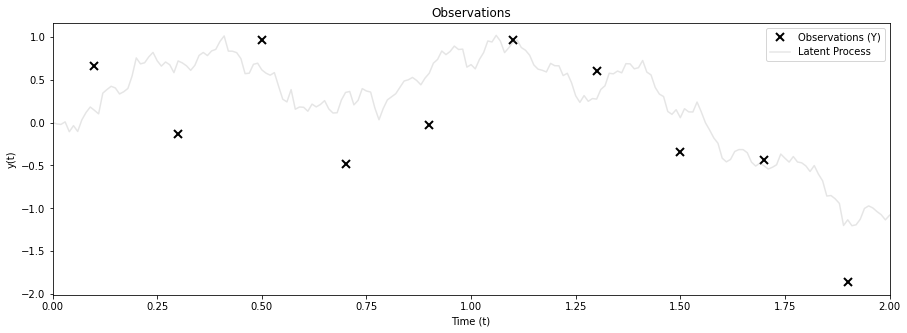

In [5]:
plot_data(obs_grid, obs_vals, time_grid, latent_p, t0, t1, "", None, None)

## Inference

In [6]:
obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))
DTYPE = default_float()

likelihood = Gaussian(noise_var)

true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorOUSDE(initial_val=decay, q=true_q)
initial_cov = q / (2 * -1 * decay)  # Steady covariance

### SDE-SSM

In [7]:
ssm_model = SDESSM(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                   learning_rate=.8)

# Setting initial state statistics
ssm_model.initial_mean = tf.zeros_like(ssm_model.initial_mean)
ssm_model.initial_chol_cov = tf.cast(tf.linalg.cholesky(tf.reshape(initial_cov, ssm_model.initial_chol_cov.shape)),
                                    dtype=DTYPE)
ssm_model.fx_covs = ssm_model.initial_chol_cov.numpy().item()**2 + 0 * ssm_model.fx_covs
ssm_model._linearize_prior()

# Performing inference
ssm_elbo, ssm_prior_prior_vals = ssm_model.run(update_prior=False)

2022-07-07 14:34:10.294838: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


SSM: Starting ELBO -14.427298606499491;
SSM: ELBO -12.23273733505996!!!
SSM: ELBO -12.189096064456024!!!
SSM: ELBO -12.18751724727043!!!
SSM: ELBO -12.187455292363294!!!
SSM: ELBO -12.187452823553846!!!
SSM: ELBO -12.187452724875028!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -12.187452724875028;!!!


## VGP

In [9]:
vgp_model = VariationalMarkovGP(input_data=obs_data,
                                prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                                lr=.1, initial_state_lr=.01)

vgp_model.p_initial_cov = tf.cast(tf.reshape(initial_cov, vgp_model.p_initial_cov.shape), dtype=DTYPE)
vgp_model.q_initial_cov = tf.identity(vgp_model.p_initial_cov)
vgp_model.p_initial_mean = tf.zeros_like(vgp_model.p_initial_mean)
vgp_model.q_initial_mean = tf.identity(vgp_model.p_initial_mean)

vgp_model.A = -1 * decay + 0. * vgp_model.A

v_gp_elbo, v_gp_prior_vals = vgp_model.run(update_prior=False)

VGP: Starting ELBO -14.427298615848015
VGP: ELBO -13.839391400326663
VGP: ELBO -13.438231101078655
VGP: ELBO -13.155115276375598
VGP: ELBO -12.950415282262902
VGP: ELBO -12.79969426141075
VGP: ELBO -12.687139575433578
VGP: ELBO -12.602138836083709
VGP: ELBO -12.537363287749573
VGP: ELBO -12.487634540131578
VGP: ELBO -12.449224572763317
VGP: ELBO -12.419407662332006
VGP: ELBO -12.396164933150509
VGP: ELBO -12.377984610468474
VGP: ELBO -12.363724066452312
VGP: ELBO -12.352512780247766
VGP: ELBO -12.343682985594347
VGP: ELBO -12.336719415958658
VGP: ELBO -12.331222444871447
VGP: ELBO -12.32688076198284
VGP: ELBO -12.323450927128166
VGP: ELBO -12.3207419437729
VGP: ELBO -12.318603533874647
VGP: ELBO -12.316917167849216
VGP: ELBO -12.31558916247286
VGP: ELBO -12.314545342620917
VGP: ELBO -12.313726893609953
VGP: ELBO -12.313087125482593
VGP: ELBO -12.312588939597436
VGP: ELBO -12.312202838722841
VGP: ELBO -12.31190535958797
VGP: ELBO -12.311677835097882
VGP: ELBO -12.31150541471183
VGP: ELB

VGP: ELBO -12.242765942960753
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.241629719577196
VGP: X0 converged!!!
VGP: ELBO -12.241629719577196
VGP: Inference converged!!!
VGP: ELBO -12.241631417468378
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.240524215804607
VGP: X0 converged!!!
VGP: ELBO -12.240524215804607
VGP: Inference converged!!!
VGP: ELBO -12.240525748201584
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.239446822420108
VGP: X0 converged!!!
VGP: ELBO -12.239446822420108
VGP: Inference converged!!!
VGP: ELBO -12.239448204657382
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.238396828247884
VGP: X0 converged!!!
VGP: ELBO -12.238396828247884
VGP: Inference converged!!!
VGP: ELBO -12.238398074365916
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.237373539640505
VGP: X0 converged!!!
VGP: ELBO -12.237373539640505
VGP: Inference converge

VGP: ELBO -12.21367608546943
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.213281625249387
VGP: X0 converged!!!
VGP: ELBO -12.213281625249387
VGP: Inference converged!!!
VGP: ELBO -12.21328163763514
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.212897204508696
VGP: X0 converged!!!
VGP: ELBO -12.212897204508696
VGP: Inference converged!!!
VGP: ELBO -12.212897214795563
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.212522553321055
VGP: X0 converged!!!
VGP: ELBO -12.212522553321055
VGP: Inference converged!!!
VGP: ELBO -12.212522561741832
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.21215742303401
VGP: X0 converged!!!
VGP: ELBO -12.21215742303401
VGP: Inference converged!!!
VGP: ELBO -12.21215742979771
VGP: Breaking q loop as ELBO converged!!!
VGP: q converged!!!
VGP: ELBO -12.2118015713579
VGP: X0 converged!!!
VGP: ELBO -12.2118015713579
VGP: Inference converged!!!
VGP:

## GPR

In [50]:
kernel = OrnsteinUhlenbeck(decay=-1*decay, diffusion=q)

gpr_model = get_gpr(obs_data, kernel, train=False, noise_stddev=np.sqrt(noise_var))

print(-1 * gpr_model.loss())

tf.Tensor(-12.189572693902107, shape=(), dtype=float64)


## Plot ELBO bound

In [53]:
decay_value_range = np.linspace(0.01, -1*decay + 5.5, 40)
ssm_elbo_vals = []
vgp_elbo_vals = []
gpr_elbo_vals = []

for decay_val in decay_value_range:
    kernel = OrnsteinUhlenbeck(decay=decay_val, diffusion=q)
    gpr_model._kernel = kernel
    gpr_elbo_vals.append(gpr_model.log_likelihood().numpy().item())
    
    ssm_model.prior_sde = PriorOUSDE(-1*decay_val, q=true_q)
    # Steady covariance
    ssm_model.initial_chol_cov = tf.linalg.cholesky((q / (2 * decay_val)) + 0. * ssm_model.initial_chol_cov)
    ssm_model._linearize_prior()  # To linearize the new prior
    ssm_elbo_vals.append(ssm_model.classic_elbo())

    vgp_model.prior_sde = PriorOUSDE(-1*decay_val, q=true_q)
    # Steady covariance
    vgp_model.p_initial_cov = (q / (2 * decay_val)) + 0. * vgp_model.p_initial_cov
    vgp_elbo_vals.append(vgp_model.elbo())

## Plotting

<Figure size 1080x360 with 0 Axes>

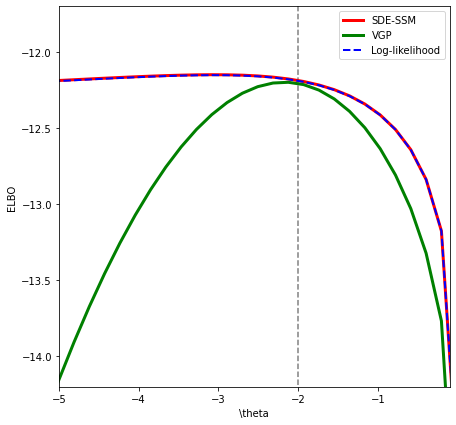

In [112]:
plt.clf()
plt.subplots(1, 1, figsize=(7, 7))
plt.plot(-1 * decay_value_range, ssm_elbo_vals, label="SDE-SSM", linewidth=3.,
         color="red")

plt.plot(-1 * decay_value_range, vgp_elbo_vals, label="VGP", linewidth=3., color="green")

plt.plot(-1 * decay_value_range, gpr_elbo_vals, label="Log-likelihood", linewidth=2., linestyle="dashed",
        color="blue")

plt.vlines(decay, np.min(vgp_elbo_vals) - 0.5, np.max(ssm_elbo_vals) + 0.5, linestyle="dashed",
           color="gray")

plt.legend(loc='upper right')
plt.xlim(-5., -0.1)
plt.ylim(-14.2, -11.7)

plt.yticks([-14, -13.5, -13, -12.5, -12])
plt.ylabel("ELBO")
plt.xlabel("\\theta")

plt.show()